## Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')


## Load data

In [2]:
df_ks = pd.read_csv('KS_train_data.csv', delimiter= ',')
data_ks_to_predict = pd.read_csv('KS_test_data.csv', delimiter= ';')

## Derive features

### Goal related feature

In [3]:
df_ks['usd_goal'] = df_ks['goal'] * df_ks['fx_rate']

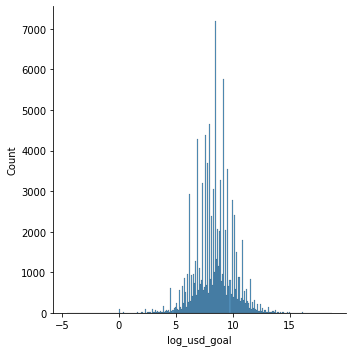

In [4]:
df_ks['log_usd_goal'] = np.log(df_ks['usd_goal'])

sns.displot(df_ks['log_usd_goal'])

### Promotion duration

In [5]:
duration = pd.to_datetime(df_ks['deadline'], unit='s') - pd.to_datetime(df_ks['launched_at'], unit='s')
df_ks['promotion_duration'] = duration / np.timedelta64(1, 'D')

count    100000.000000
mean         33.840738
std          12.953758
min           1.000000
25%          30.000000
50%          30.000000
75%          36.000000
max          91.958333
Name: promotion_duration, dtype: float64

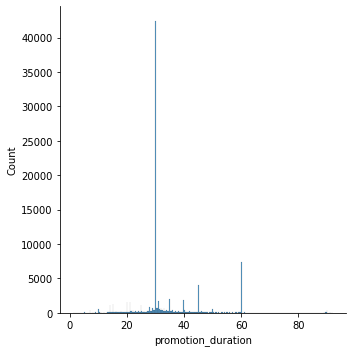

In [6]:
sns.displot(df_ks['promotion_duration'])
df_ks['promotion_duration'].describe()

In [7]:
top_10 = df_ks['promotion_duration'].value_counts()[:10].index
print(top_10)

Float64Index([              30.0,               60.0, 29.958333333333332,
              30.041666666666668,               45.0,               40.0,
                            35.0, 60.041666666666664,               20.0,
              59.958333333333336,               21.0,               15.0,
                            25.0,               31.0,               14.0,
                            28.0, 44.958333333333336,               10.0],
             dtype='float64')


### Encode country and category

In [8]:
from sklearn import preprocessing

#creating labelEncoder
le = preprocessing.LabelEncoder()

In [9]:
# Converting string labels into numbers.
df_ks['country_encoded'] = le.fit_transform(df_ks['country'])

# print(df_ks['country_encoded'] )

In [10]:
df_ks['category_encoded'] = le.fit_transform(df_ks['category'])

#print(df_ks['category_encoded'])

### One-hot Encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

enc_category = pd.DataFrame(enc.fit_transform(df_ks[['category']]).toarray())

In [12]:
df_ks = df_ks.join(enc_category)

In [13]:
enc_country = pd.DataFrame(enc.fit_transform(df_ks[['country']]).toarray())

In [ ]:
# 同样的Head和category冲突 （0-14部分）
# df_ks = df_ks.join(enc_country)

## Model Training

### Choose features

In [24]:

# 1号
# Random Forest中Train最高的features （Train：0.89， Test：0.69 ）明显 Overfit
# KNN（Train：0.70， Test：0.69）
#features = ['log_usd_goal','promotion_duration','country_encoded','category_encoded','staff_pick']
# Random Forest（Train：0.78， Test：0.70 ）Overfit 的元凶就是promotion_duration
#features = ['log_usd_goal','country_encoded','category_encoded','staff_pick']

# 2号
# 没有country 在KNN中反而分数更高，但是不明显（Train: 0.71, Test: 0.7)
# Random Forest中Train略有下降，但依然Overfit （Train：0.88， Test：0.69）
#features = ['log_usd_goal','promotion_duration','category_encoded','staff_pick']

# 9号
# 没有promotion之后，RF的Overfit情况明显好转
# Random Forest（Train：0.764， Test：0.7006）
features = ['log_usd_goal','category_encoded','staff_pick']

# 3号
# 没有category 只有country 的 KNN得分 （Train：0.68， Test：0.67）
# Random Forest test下降，说明category有用 （Train：0.83， Test：0.67）
#features = ['log_usd_goal','promotion_duration','country_encoded','staff_pick']

# 4号
# Categorical Features Only
# KNN （Train：0.675， Test: 0.66）说明Numerical Feature还是有用的
# Random Forest (Train : 0.68, Test: 0.66) 分数下降，但是Overfit的情况有所好转
#features = ['country_encoded','category_encoded','staff_pick']

# 5号
# Continuous Numerical Features Only
# KNN （Train：0.659， Test: 0.6521）两个分数非常接近，没有overfit，但分数不高，还是underfit了
# Random Forest (Train : 0.79, Test: 0.63) Overfit情况非常严重 两个model在这里分歧较大
#features = ['log_usd_goal','promotion_duration']

# 6号
# 替换category_encoded成 one-hot encoded
# KNN （Train：0.690， Test: 0.678）
# Random Forest (Train : 0.868, Test: 0.658)
#features = ['log_usd_goal','promotion_duration',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]

# 7号
#Discrete numerical features only (KNNTraining 和 Test非常的接近，但是都不高，0.66左右)
# 可以预见的underfit
# KNN （Train：0.651， Test: 0.6499）分数接近
# Random Forest (Train : 0.667, Test: 0.667) RF分数最接近的一次
#features = ['staff_pick',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]

# 8号
# 与KNN表现最好features相比，替换encode category的方法，最后结果差不多，encode方法没有影响到KNN，
# 但根据网上调查结果和课上一直强调的内容，应该用one-hot encoding而不是labeling
# KNN （Train：0.719， Test: 0.7064）
# Random Forest (Train : 0.8857, Test: 0.6941)
#features = ['log_usd_goal','promotion_duration','staff_pick',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]

# KNN （Train：0.710， Test: 0.7037）
features = ['log_usd_goal','staff_pick',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]


X = df_ks[features]
y = df_ks['funded']

### Split dataset

#### One-fold

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### KNN

#### Validation Curve

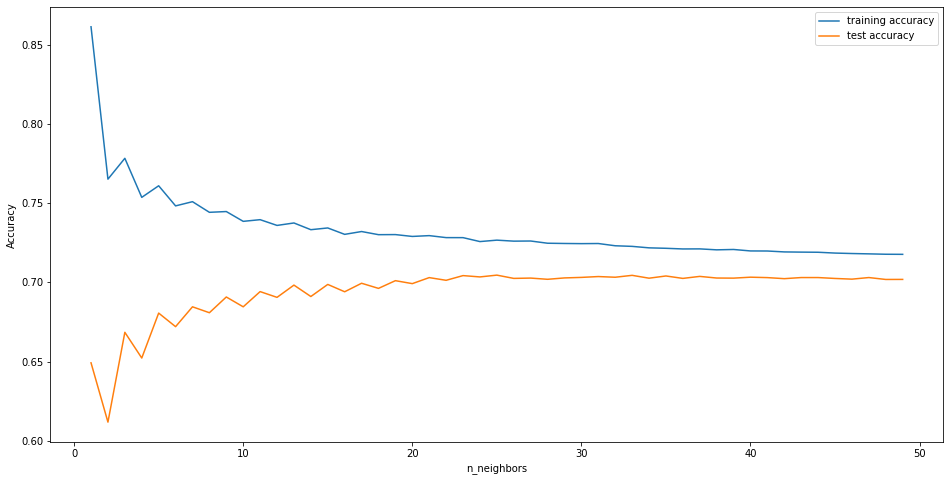

In [138]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 50)
for n_neighbors in neighbors_settings:
 # build the model
 clf = KNeighborsClassifier(n_neighbors=n_neighbors)
 clf.fit(X_train, y_train)
 # record training set accuracy
 training_accuracy.append(clf.score(X_train, y_train))
 # record generalization accuracy
 test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=48)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=48)

In [27]:
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.7103142857142857
0.7037


In [ ]:
from sklearn import metrics

y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#### Cross-validation

In [122]:
# 8号features

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)

cross_val_score(knn, X, y, cv = 10)

array([0.6377, 0.64  , 0.482 , 0.6734, 0.6697, 0.6681, 0.6701, 0.6485,
       0.7159, 0.6403])

### Random Forests

In [28]:
#Random forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.8,
                  n_estimators=100)

In [29]:
print(bag.score(X_train, y_train))
print(bag.score(X_test, y_test))

0.7790428571428571
0.7041666666666667


#### RF Cross-validation

In [120]:
# 2号 features
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)

cross_val_score(bag, X, y, cv = 10)

array([0.6466, 0.614 , 0.4642, 0.6653, 0.6748, 0.6701, 0.6631, 0.6331,
       0.6772, 0.5497])

## Prediction

df_res['project_id']
df_res['prediction'] = model.predic()

In [ ]:
yourDataframe.to_csv('predictions.tsv', delimiter='\t', columns=['project_id','prediction'])